In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from statistics import mean
import joblib 

STEP 1. LOOK AT THE BIG PICTURE (DONE)

STEP 2. GET THE DATA (DONE). LOAD DATA

In [79]:
raw_data = pd.read_csv(r'dataset/Data.csv')
# raw_data.head(10) preview the first 10 column
#raw_data.tail() preview the last 10 column 

STEP 3. DISCOVER THE DATA TO GAIN INSIGHTS

In [80]:
# 3.1 Quick view of the data
print('\n____________ Dataset info ____________')
print(raw_data.info())              
print('\n____________ Some first data examples ____________')
print(raw_data.head(5)) 
print('\n____________ Counts on a feature ____________')
# print(raw_data['LEGAL DOCUMENTS'].value_counts()) 
print('\n____________ Statistics of numeric features ____________')
print(raw_data.describe())    
print('\n____________ Get specific rows and cols ____________')     
print(raw_data.iloc[[0,1,45], [2, 5]] ) # Refer using column ID



____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1694 entries, 0 to 1693
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1694 non-null   object 
 1   datetime          1694 non-null   object 
 2   tempmax           1694 non-null   float64
 3   tempmin           1694 non-null   float64
 4   temp              1694 non-null   float64
 5   feelslikemax      1694 non-null   float64
 6   feelslikemin      1694 non-null   float64
 7   feelslike         1694 non-null   float64
 8   dew               1694 non-null   float64
 9   humidity          1694 non-null   float64
 10  precip            1694 non-null   float64
 11  precipprob        1694 non-null   int64  
 12  precipcover       1694 non-null   float64
 13  preciptype        1238 non-null   object 
 14  snow              1694 non-null   int64  
 15  snowdepth         1694 non-null   int64  
 16  wi

In [82]:
corr = raw_data.corr(numeric_only=True)
corr

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,year
tempmax,1.000000,0.910488,0.977956,0.967255,0.894834,0.958574,0.843498,0.019068,0.049157,0.111252,...,0.165546,-0.833873,-0.355167,0.410551,0.688866,0.688858,0.649357,0.618100,0.018809,0.029734
tempmin,0.910488,1.000000,0.970311,0.909554,0.965491,0.942918,0.929856,0.226682,0.124693,0.288723,...,0.116602,-0.872584,-0.077446,0.331611,0.484935,0.484950,0.458399,0.619503,0.030147,0.035271
temp,0.977956,0.970311,1.000000,0.958500,0.946734,0.976181,0.901569,0.106566,0.082053,0.192305,...,0.145685,-0.872574,-0.233046,0.390361,0.607984,0.607951,0.571432,0.630013,0.023695,0.030491
feelslikemax,0.967255,0.909554,0.958500,1.000000,0.902449,0.979793,0.861300,0.091647,0.088091,0.173660,...,0.125846,-0.867431,-0.279716,0.431606,0.663925,0.663943,0.626008,0.729384,0.012647,0.079145
feelslikemin,0.894834,0.965491,0.946734,0.902449,1.000000,0.953917,0.870404,0.137210,0.073598,0.218577,...,0.110917,-0.854342,-0.116564,0.373568,0.524651,0.524597,0.483753,0.638955,0.026240,0.037422
feelslike,0.958574,0.942918,0.976181,0.979793,0.953917,1.000000,0.873631,0.085385,0.067143,0.187403,...,0.119658,-0.879639,-0.235492,0.437497,0.631813,0.631748,0.585639,0.712797,0.014958,0.062769
dew,0.843498,0.929856,0.901569,0.861300,0.870404,0.873631,1.000000,0.523397,0.187208,0.407748,...,0.098594,-0.874495,0.001286,0.134484,0.385527,0.385500,0.364550,0.623843,0.022799,0.104210
humidity,0.019068,0.226682,0.106566,0.091647,0.137210,0.085385,0.523397,1.000000,0.281300,0.549833,...,-0.044116,-0.299011,0.453813,-0.478047,-0.307654,-0.307634,-0.286967,0.192601,0.012031,0.180143
precip,0.049157,0.124693,0.082053,0.088091,0.073598,0.067143,0.187208,0.281300,1.000000,0.212100,...,0.070531,-0.186998,0.156305,0.016742,-0.177469,-0.177362,-0.173480,0.039918,0.010903,0.022536
precipprob,0.111252,0.288723,0.192305,0.173660,0.218577,0.187403,0.407748,0.549833,0.212100,1.000000,...,-0.064879,-0.264012,0.395106,-0.105029,-0.275579,-0.275511,-0.252259,0.218632,0.003418,0.033591


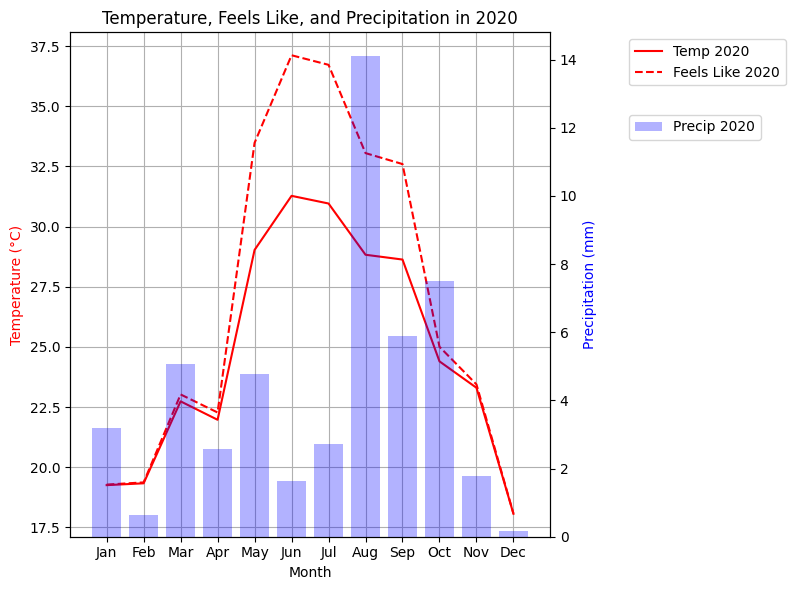

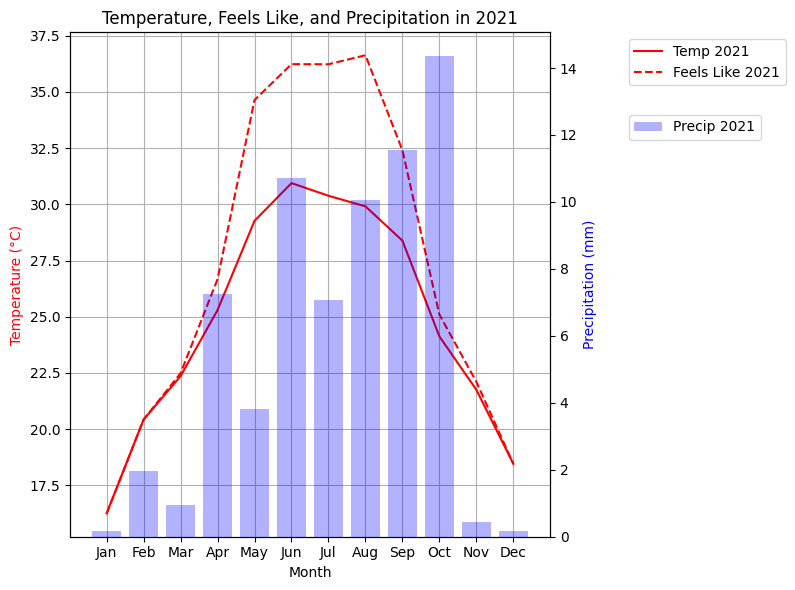

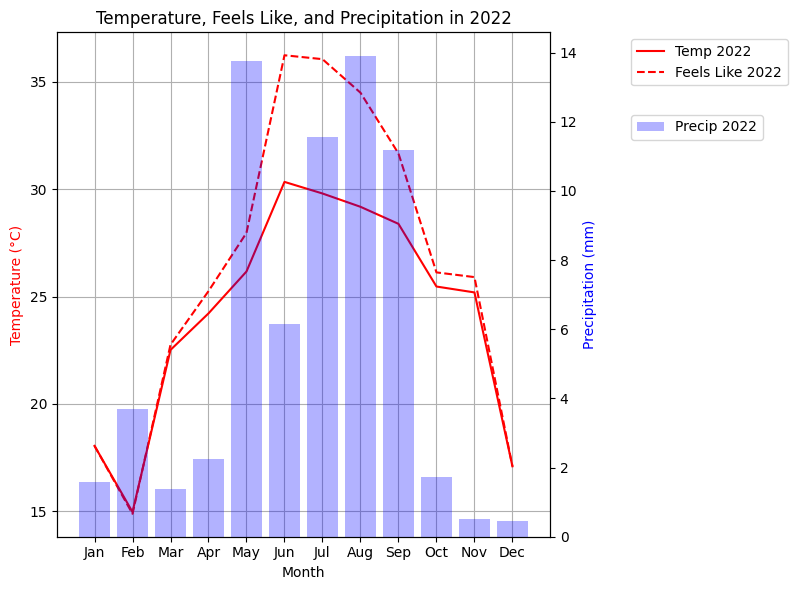

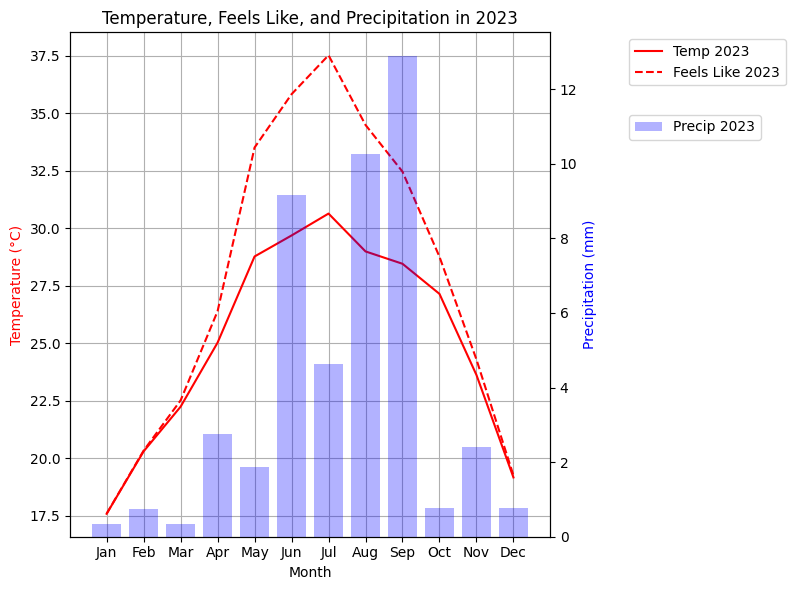

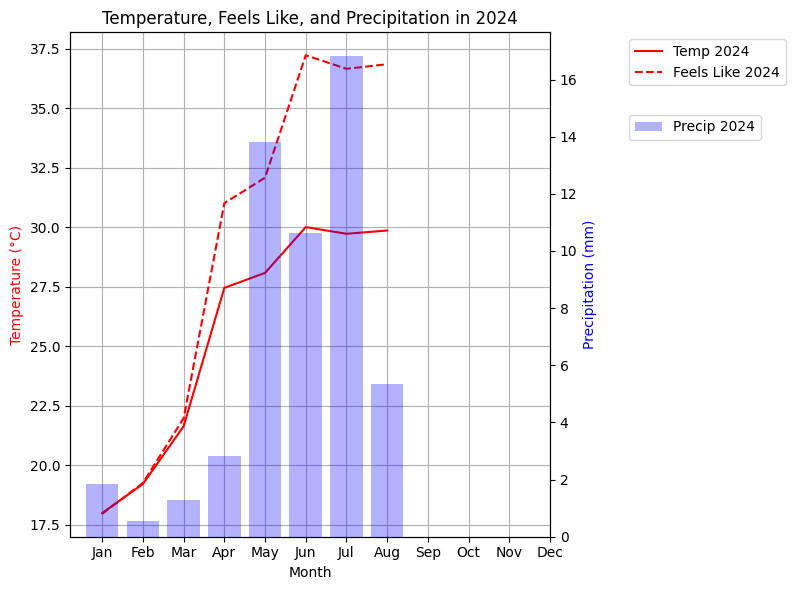

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
raw_data = pd.read_csv(r'dataset/Data.csv')

# Convert 'datetime' column to pandas datetime
raw_data['datetime'] = pd.to_datetime(raw_data['datetime'])

# Extract the year from the 'datetime' column into a new 'year' column
raw_data['year'] = raw_data['datetime'].dt.year

# Filter data for the years 2020 to 2024
years = [2020, 2021, 2022, 2023, 2024]
filtered_data = raw_data[raw_data['year'].isin(years)]

# Group the data by year and month, and calculate the average temp, feels like, and precip for each month
monthly_avg = filtered_data.groupby([filtered_data['datetime'].dt.month, filtered_data['datetime'].dt.year])[['temp', 'feelslike', 'precip']].mean().unstack(1)

# Define month names for the x-axis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Function to plot the data for each year
def plot_year_data(year):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax2 = ax.twinx()  # Create a secondary axis for the bar chart

    # Plot temperature and feels like as line charts
    ax.plot(monthly_avg.index, monthly_avg['temp'][year], label=f'Temp {year}', color='red')
    ax.plot(monthly_avg.index, monthly_avg['feelslike'][year], label=f'Feels Like {year}', color='red', linestyle='dashed')

    # Plot precipitation as a bar chart
    ax2.bar(monthly_avg.index, monthly_avg['precip'][year], color='blue', alpha=0.3, label=f'Precip {year}')

    # Set the axis labels and title
    ax.set_title(f'Temperature, Feels Like, and Precipitation in {year}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature (°C)', color='red')
    ax2.set_ylabel('Precipitation (mm)', color='blue')

    # Set custom month labels on the x-axis
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(months)

    # Add legends outside of the plot area, further right
    ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))

    # Grid for better readability
    ax.grid(True)

    # Adjust layout and leave space for the legends
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Plot the data for each year separately (2020 to 2023)
for year in years[:-1]:  # Exclude 2024
    plot_year_data(year)

# Plot the data for 2024 in a separate figure
plot_year_data(2024)